## Example workflow for bridging patents to academic validation

In [6]:
#!pip install google-search-results

In [7]:
#!pip install pandas
#!pip install numpy
#!pip install scipy
#!pip install matplotlib
#!pip install seaborn
#!pip install scikit-learn


In [9]:
!pip install wordcloud

In [10]:
from serpapi import GoogleSearch
import re
import pandas as pd
import numpy as np
import scipy
import sklearn as sk
import matplotlib.pyplot as plt

In [14]:
def getPatentNumber(text):
    patent_number="NA"
    text = "patent/CN115329779B/en"
    match = re.search(r"[A-Z]{2}\d+[A-Z0-9]", text)
    if match:
        patent_number = match.group(0)
    return patent_number

In [15]:
endpt='https://serpapi.com/search?engine=google_patents'


In [16]:
apiKey='your_api_key' # you need to get this after registering on https://serpapi.com/

In [17]:
params = {
    "engine": "google_patents",
    "q": "visual language models",   # your query
     "cpc": "G06T",                # filter by cpc
    "after": "filing:20200101",           # patents filed after Jan 1, 2020
    "num": "100",                          # results per page (10–100)
    "api_key": apiKey
}

In [18]:
search = GoogleSearch(params)
results = search.get_dict()

In [19]:
print(type(results))
#print(results) #Uncomment if you really want see the contents

<class 'dict'>


In [51]:
columns=['PN', 'Ti','Abs']
df=pd.DataFrame(columns=columns)

In [52]:
# Use enumerate for the counter (cleaner than i=i+1)
toPrint=False
for i, patent in enumerate(results.get("organic_results", []), 1):
    
    # 1. Extract Patent Number safely (Splitting 'patent/CN115329779B/en')
    raw_id = patent.get("patent_id", "")
    patent_number = raw_id.split('/')[1] if '/' in raw_id else raw_id
    
    # 2. Get Title and CPC (providing a default "N/A" if missing)
    title = patent.get("title", "No Title")
    cpc = patent.get("cpc", "N/A") 
    snippet = patent.get("snippet", "No Abstract")

    # 3. Print formatted results
    if (toPrint):
        print(f"{i}.\n")
        print(f"{patent_number}")
        print(f"{title}")
        #print(f" cpc = {cpc}")
        print(f"Snippet : {snippet}")
        print(f"Full ID: {raw_id}") 
    #print("-" * 40) # Visual separator
    df.loc[len(df)]=[patent_number,title,snippet]

In [53]:
#df.head()

In [55]:
print(df.shape)

(100, 3)


In [56]:
#Concatenating Textual Content
df['concat']=df["Ti"]+df["Abs"]

In [57]:
from sklearn.feature_extraction import text
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [59]:
tfidfVec=TfidfVectorizer(max_df=1.,min_df=1,stop_words='english',ngram_range=(2, 2))

In [60]:
df.columns

Index(['PN', 'Ti', 'Abs', 'concat'], dtype='object')

In [61]:
doc_term_matrix =tfidfVec.fit_transform(df['concat'].replace('\d+', '', regex=True).values.astype('U'))

In [62]:
from sklearn.decomposition import NMF

In [63]:
topic_count=10
nmf=NMF(n_components=topic_count,random_state=42)

In [64]:
nmf.fit(doc_term_matrix)

,n_components,10
,init,None
,solver,'cd'
,beta_loss,'frobenius'
,tol,0.0001
,max_iter,200
,random_state,42
,alpha_W,0.0
,alpha_H,'same'
,l1_ratio,0.0
,verbose,0


In [65]:
W=nmf.fit_transform(doc_term_matrix)  # Document-topic matrix

In [66]:
H=nmf.components_
print(H)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.00135532 ... 0.00295661 0.00295661 0.        ]
 ...
 [0.         0.         0.00150047 ... 0.         0.         0.01708932]
 [0.         0.         0.         ... 0.         0.         0.00379984]
 [0.09471527 0.18943055 0.         ... 0.         0.         0.        ]]


In [69]:
#This is for Plotting
x1=np.array([0, 1,2,3,4,5,6,7,8,9])
x2=np.reshape(x1,(-1,2))


In [70]:
from wordcloud import WordCloud, STOPWORDS

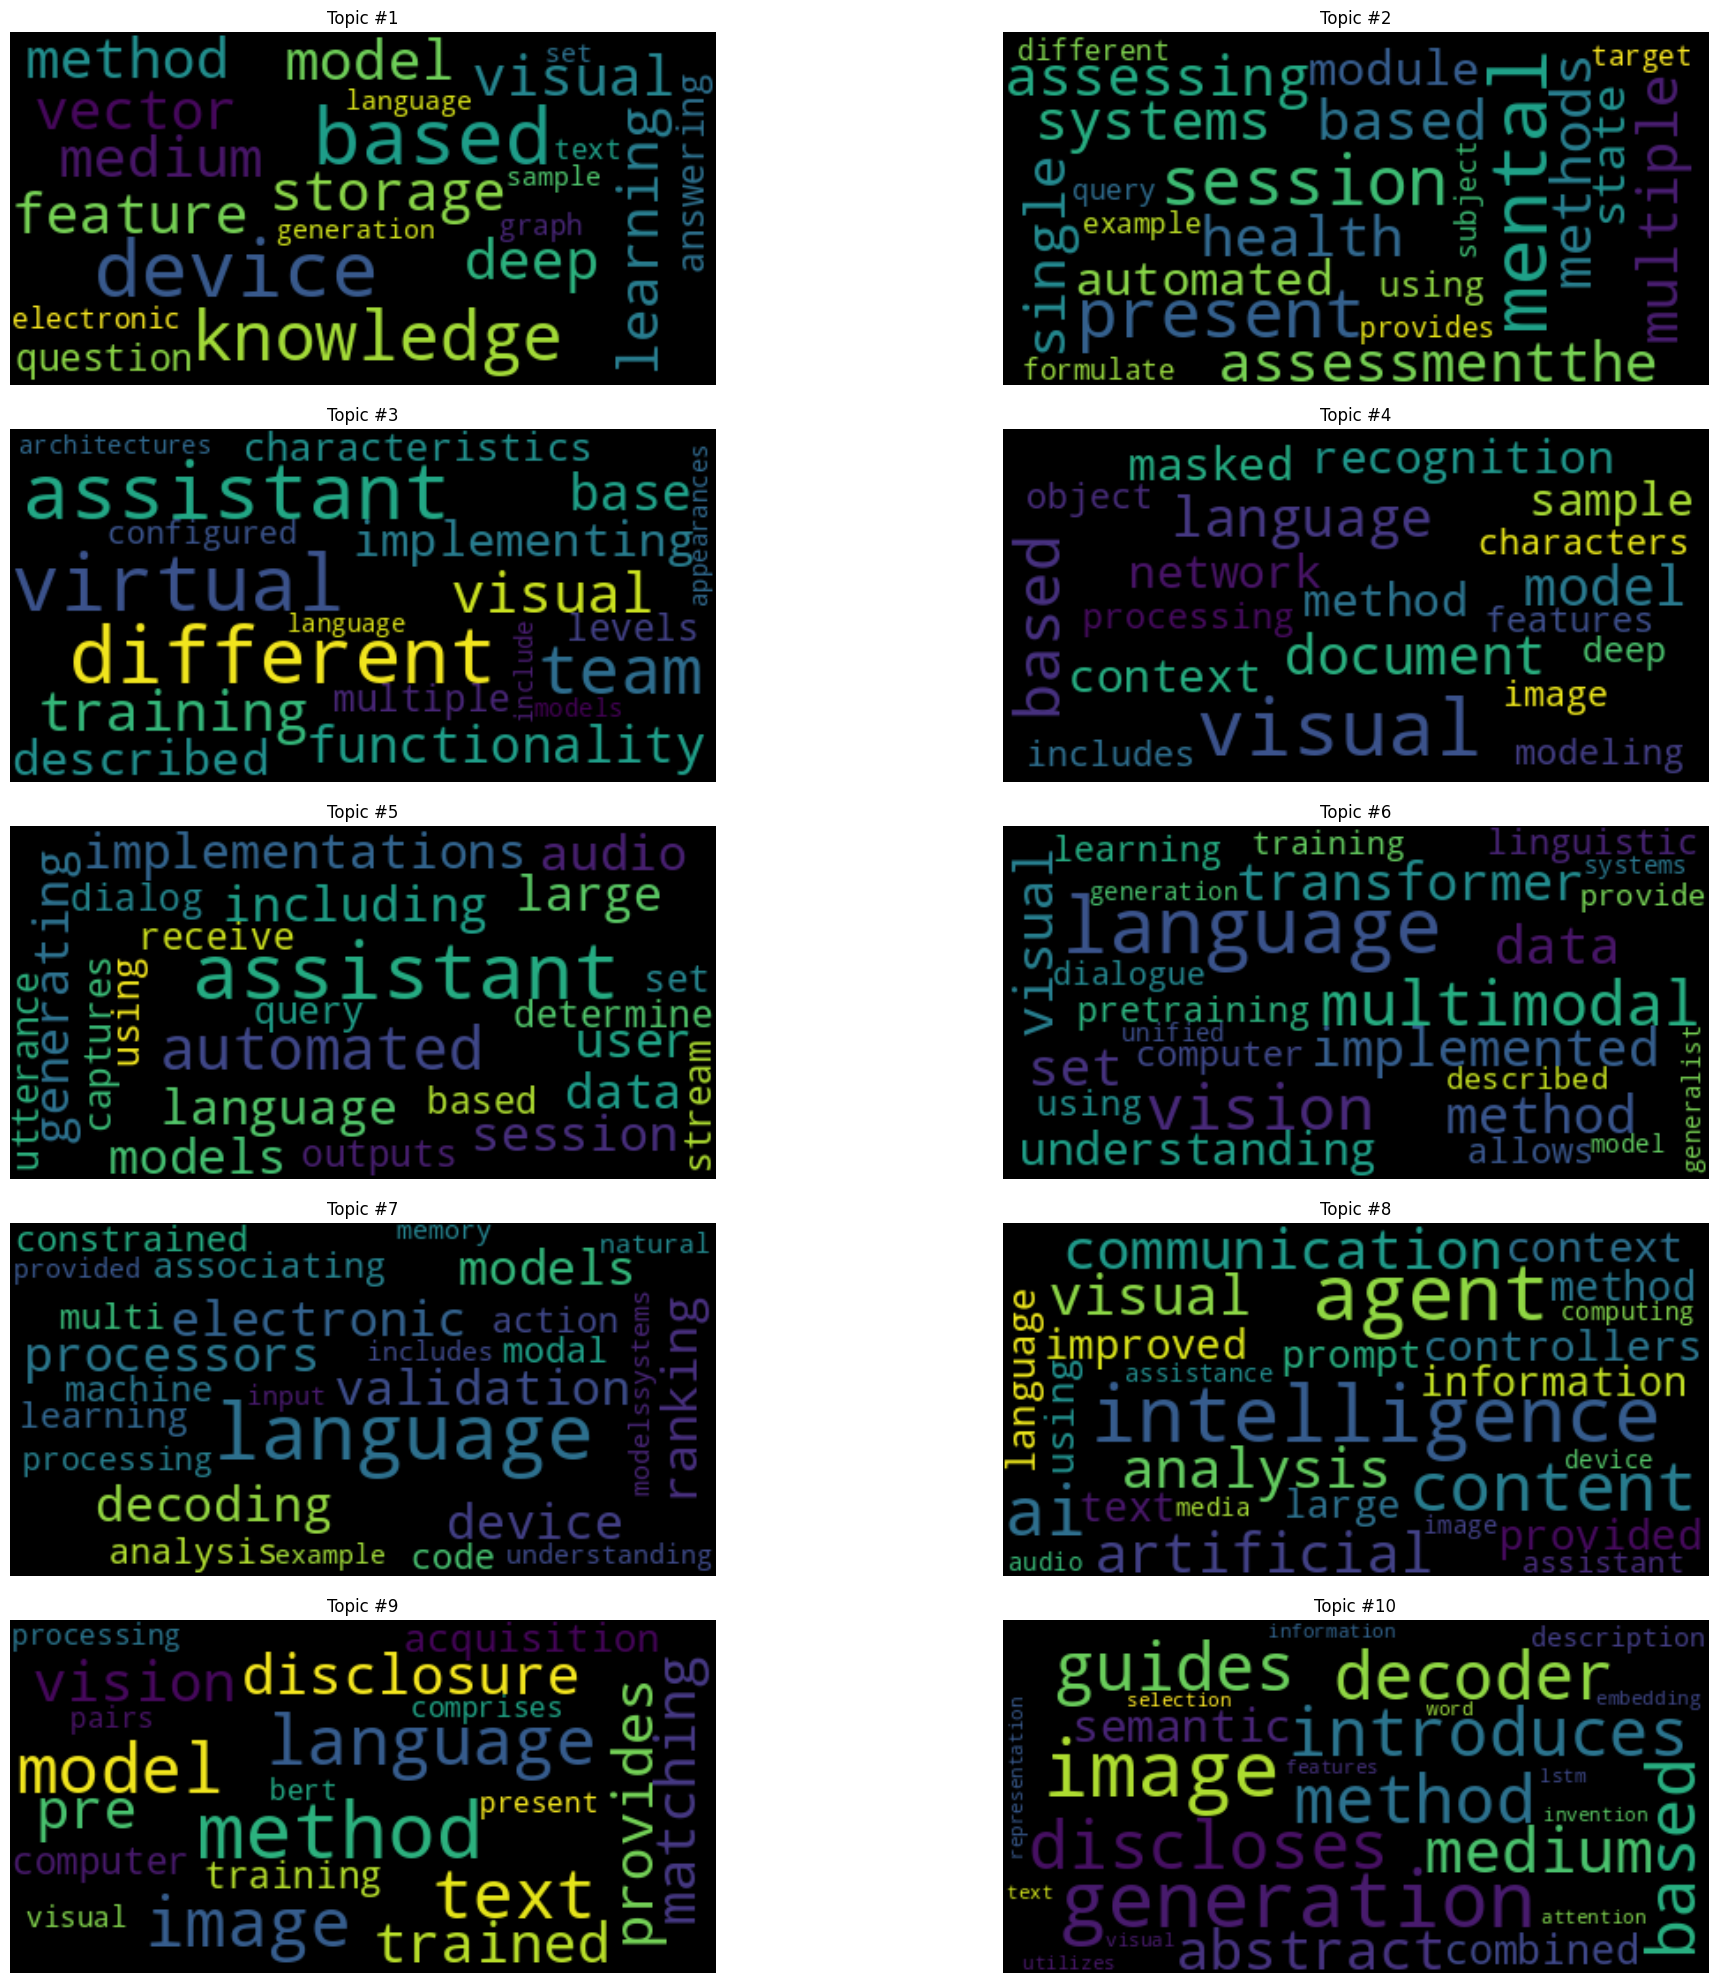

In [71]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))
#fig = plt.figure(figsize=figsize)
fig.tight_layout()
for i in np.arange(0,5):
    mat=x2[i,:]
    #print(str(mat))
    axs1 = axs[i,0]#fig.add_subplot(mat[0]+1,2,1)
    topic=nmf.components_[mat[0]]
    topic_ref=topic.argsort()[-20:]
    s = ' - '.join(tfidfVec.get_feature_names_out()[topic_ref])
    
    axs1.set_title("Topic #" + str(mat[0]+1))
    wordcloud = WordCloud(max_font_size=45).generate(s)
    axs1.imshow(wordcloud,interpolation="bilinear")
    axs1.axis('off')
    axs2 = axs[i,1]
    #axs2 = fig.add_subplot(mat[0]+1,2,2)
    topic=nmf.components_[mat[1]]
    topic_ref=topic.argsort()[-20:]
    s = ' - '.join(tfidfVec.get_feature_names_out()[topic_ref])
    
    axs2.set_title("Topic #" + str(mat[1]+1))
    wordcloud = WordCloud(max_font_size=45).generate(s)
    axs2.imshow(wordcloud,interpolation="bilinear")
    axs2.axis('off')
   

In [72]:
# Choose a topic of interest
topic_id = 6 # example topic index

In [73]:
# Get scores for this topic across all documents
topic_scores = W[:, topic_id]
print(topic_scores)

[0.06111224 0.         0.         0.         0.00957505 0.
 0.         0.         0.07231684 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00062356 0.00817409 0.         0.         0.00590936 0.06414136
 0.         0.         0.         0.0005458  0.         0.
 0.         0.         0.         0.         0.03610562 0.
 0.         0.         0.         0.03210908 0.00577931 0.
 0.         0.         0.         0.         0.02395657 0.00194808
 0.03170488 0.08547408 0.35494681 0.         0.         0.1580797
 0.14026652 0.00233847 0.         0.         0.         0.00063574
 0.         0.         0.         0.         0.31255529 0.19148452
 0.034534   0.0195624  0.         0.         0.1691692  0.04628442
 0.00635192 0.         0.         0.         0.27647205 0.48778254
 0.         0.         0.         0.02843455 0.         0.
 0.03412172 0.         0.05954194 0.         0.         0.42126273
 0.         0.15234399 0.01726585 0.         0.     

In [75]:
# Rank documents by their topic score
top_doc_indices = np.argsort(topic_scores)[::-1]
print(top_doc_indices)

[77 89 50 64 76 96 95 65 70 53 91 54 49  8 23  0 86 71 98 34 66 84 39 48
 81 46 67 92  4 19 72 22 40 55 47 59 18 27 69 68 79 75 73 93 88 90 94 87
 85 83 82 80 99 97 74 78 60 43 44 45 51 52 61 62 56 57 58 63 32 33 35 36
 38 37 42 41 24 25 26 28 20 31 29 30 16 17 21 15 12 11 13 14  9 10  6  7
  5  3  2  1]


In [76]:
top_n = 5 # top Five Documents
best_docs = df['concat'].iloc[top_doc_indices[:top_n]]
best_patents = df['PN'].iloc[top_doc_indices[:top_n]]

print("Top documents for Topic", topic_id)
for i, (doc, pn) in enumerate(zip(best_docs, best_patents), 1):
    print(f"{i}. Patent {pn} → {doc[:200]}...")

Top documents for Topic 6
1. Patent US20220084511A1 → Using augmentation to create natural language modelsSystems and processes for creating and updating natural language models are provided. An example process of creating a natural language model includ...
2. Patent US11842727B2 → Natural language processing with contextual data representing displayed contentMulti-modal natural language processing systems are provided. Some systems are context-aware systems that use multi-modal...
3. Patent US20230325154A1 → Constrained decoding and ranking of language models for code generationIn various embodiments, a process for constrained decoding and ranking of language models for code generation includes receiving ...
4. Patent US20210334474A1 → Natural Language System and MethodsA natural language understanding (NLU) system utilizes a knowledge network having interconnected actor perceiver predictor (APP) nodes associated with context, actio...
5. Patent US11829720B2 → Analysis and validation 

In [79]:
# The Bridge: From Patent to Academic Validation

# IMPORTANT: You must include the 'api_key' in this new dictionary too
scholar_params = {
    "engine": "google_scholar",
    "q": "visual language models",
    "num": 5,
    "api_key": params['api_key'] # Reuse the key from the first params
}

# 5. Initialize a NEW search object for the second query
scholar_search = GoogleSearch(scholar_params)

# 6. Get Scholar results
scholar_results = scholar_search.get_dict()


# --- PART 3: MEASURE IMPACT ---

cited_by_count = 0
if 'organic_results' in scholar_results:
    first_paper = scholar_results['organic_results'][0]
    
    # Safely traverse the nested JSON
    # Structure: inline_links -> cited_by -> total
    cited_by_count = first_paper.get('inline_links', {}).get('cited_by', {}).get('total', 0)

print(f"Academic Citations found: {cited_by_count}")

Academic Citations found: 571


In [ ]:
'''
import requests

# REPLACE THIS WITH YOUR ACTUAL API KEY
MY_API_KEY = apiKey #"YOUR_SERPAPI_KEY_HERE" 

# Configuration
TARGET_COUNTRIES = ["US", "EP", "WO"]
MAX_TO_PROCESS = 5
processed_count = 0
organic_results = results.get("organic_results", [])

print(f"Searching for first {MAX_TO_PROCESS} patents from {TARGET_COUNTRIES}...\n")

for patent in organic_results:
    if processed_count >= MAX_TO_PROCESS:
        break

    # 1. Identify Country
    pub_num = patent.get("publication_number", "")
    if not pub_num and "/" in patent.get("patent_id", ""):
        pub_num = patent.get("patent_id", "").split("/")[1]
    
    country_code = pub_num[:2].upper()

    if country_code in TARGET_COUNTRIES:
        processed_count += 1
        title = patent.get("title", "No Title")
        details_url = patent.get("serpapi_link")

        print(f"[{processed_count}/{MAX_TO_PROCESS}] FOUND {country_code}: {pub_num}")
        
        if details_url:
            print("   Fetching classifications...")
            try:
                # --- THE FIX IS HERE ---
                # We pass the API key in the 'params' dictionary
                response = requests.get(details_url, params={"api_key": MY_API_KEY})
                response.raise_for_status()
                
                details_data = response.json()
                classifications = details_data.get("classifications", [])

                if classifications:
                    for item in classifications[:3]:
                        print(f"     - {item.get('code')}: {item.get('description')}")
                else:
                    print("     No classifications data found.")

            except Exception as e:
                print(f"     Error: {e}")
        
        print("-" * 50)
'''